# Análisis de los datos

In [1]:
# importar librerias necesarias
import pandas as pd # para manejar dataframes
import matplotlib.pyplot as plt

In [2]:
# dataframe con toda la informacion recompilada de RawData
df_data = pd.read_csv('../csvFiles/raw_pacientes.csv', dtype=object) # salida de leer_dataset.ipynb
df_data.head() # visualizacion de la cabecera

,SubjectID,DateID,GestureLabel,RepetitionNumber,CorrectLabel,Position,JointName,TrackedStatus,3D_X,3D_Y,3D_Z,2D_X,2D_Y
0,101,18,0,1,1,stand,SpineBase,Tracked,-0.1028086,0.06965441,2.464606,243.133,196.5854
1,101,18,0,1,1,stand,SpineMid,Tracked,-0.1026228,0.3837799,2.438919,242.971,149.1077
2,101,18,0,1,1,stand,Neck,Tracked,-0.1025293,0.6877351,2.40196,242.6967,101.3569
3,101,18,0,1,1,stand,Head,Tracked,-0.1190992,0.8358598,2.373549,239.9086,76.90204
4,101,18,0,1,1,stand,ShoulderLeft,Tracked,-0.2826451,0.5525576,2.38421,214.7496,121.544


In [4]:
# dataframe de los ángulos
# dataframe con toda la informacion recompilada de RawData
df_angle = pd.read_csv('../csvFiles/angles.csv', dtype=object) # salida de leer_dataset.ipynb
df_angle.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,ElbowAngleLeft,ElbowAngleRight,ShoulderAngleLeft,ShoulderAngleRight,WristAngleLeft,WristAngleRight,HipAngleLeft,KneeAngleLeft,AnkleAngleLeft,HipAngleRight,KneeAngleRight,AnkleAngleRight,LeftArmAngle,RightArmAngle,ArmsTogetherAngle
0,101,0,1,1,stand,177.9533783802923,177.47078566610173,36.30705079408196,38.46939873065676,177.63316067999565,173.74983809083764,72.807308584356,177.58861970254094,171.10956913578713,76.45745319526256,175.75458949602438,153.54240691213994,23.17424402567692,19.93582991813402,25.940740061640934
1,101,0,1,1,stand,177.6519979832311,177.3758667976079,36.12535922749934,38.3929855113577,177.90747805542844,174.63598398681086,72.87923637280247,177.54157386533907,171.13439798720057,76.38619060250949,175.71655555143224,153.55852641631657,23.29910696469033,19.80450989780968,25.91884307939421
2,101,0,1,1,stand,177.8945658753998,177.31856423320372,36.197693392043035,38.51644217201674,177.78659806687222,175.0906343385824,72.77923316512522,177.38609237331696,170.69070831128238,76.49057870816041,175.8631151838647,155.22607453288742,23.219500260654,19.60822436010641,25.930797781797324
3,101,0,1,1,stand,177.68526830845906,176.46739614607876,36.128257264925445,38.44611253180486,177.13837106978346,176.7734964092055,72.79731117350583,177.48222648758292,172.0421352388088,76.55952893680258,176.0038865477014,156.60083972381202,23.247389705591196,19.297084757568626,25.87934987896583
4,101,0,1,1,stand,177.85607492467966,176.22026175097926,36.21791735131648,38.51367442426501,176.37198799790454,177.54591626292546,72.70357873889527,177.37431548422322,172.30684973705291,76.67842468232598,176.063349663432,156.45034414294915,23.165203251042666,19.25821394620917,25.8593946020372


## 1. Posición a través de t

Posición de la muñeca de una persona sana (102) vs un paciente (id: 206) realizando una flexión de hombro

In [5]:
def repetition_graph(df:pd.DataFrame, keyPoint:str, movementAxis:str):
    """
    Crea una gráfica donde se representa la posición de un keypoint frente al tiempo (frame).
    Cada línea representa una repetición distinta.
    """
    groups = df.groupby("RepetitionNumber") # agrupa el dataframe según la repeticion
 
    for name, group in groups:
        spinBase = group[group['JointName']=='SpineBase'][movementAxis] # cogemos tambien la posicion de la base de la columna para poder normalizar los datos
        WristRight = group[group['JointName']==keyPoint][movementAxis]
        normalize_gesture = WristRight.values - spinBase.values
        plt.plot(normalize_gesture, label = "repetition "+ str(name))
        plt.xlabel("Posición en el eje x")
        plt.ylabel("Frame number")

In [6]:
def extraer_persona(df:pd.DataFrame, id:str, id_gesture:list[str]) -> pd.DataFrame:
    """
    Crea un dataframe la posición de los keypoints referente a un moviento de una persona
    """
    conditions = (df['SubjectID'] == id) & (df['GestureLabel'].isin(id_gesture) )  & (df['Position'] =='stand')
    persona = df[conditions]
    persona = persona.apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
    return persona

In [7]:
# seleccionamos a las dos personas
persona_sana = extraer_persona(df_data, '102', ['2'])
paciente_206 = extraer_persona(df_data, '206', ['2'])

C:\Users\nerea\AppData\Local\Temp\ipykernel_5516\1655749113.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  persona = persona.apply(lambda x: pd.to_numeric(x, errors = 'ignore'))


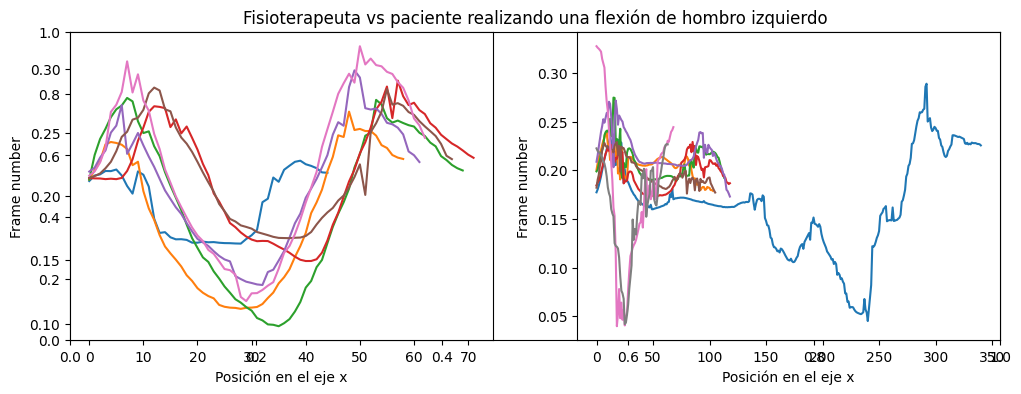

In [8]:
# creamos una gráfica para cada persona
fig = plt.figure(figsize=(12, 4))
plt.title('Fisioterapeuta vs paciente realizando una flexión de hombro izquierdo')
plt.subplot(1, 2, 1)
repetition_graph(persona_sana, 'WristRight', '3D_X')

plt.subplot(1, 2, 2)
repetition_graph(paciente_206, 'WristRight', '3D_X')

plt.show()

## 2. Numero de correctas e incorrectas (class imbalance)

* CorrectLabel: A value of 1 represents a gesture labeled as being correctly executed, while a value of 2 is for a gesture labeled as incorrect

QUE HACER CON CorrectLabel = 3

Text(0, 0.5, 'Number of Patients')

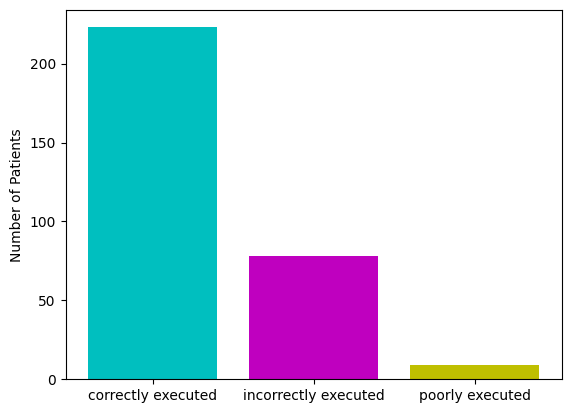

In [9]:
df_peque = df_data[['SubjectID', 'GestureLabel', 'CorrectLabel']].drop_duplicates().reset_index(drop=True)

df_peque = df_peque.groupby(['CorrectLabel']).count()

x = ["correctly executed", "incorrectly executed", "poorly executed"]
color =  ['c', 'm', 'y']
plt.bar(x, df_peque['GestureLabel'].values, color=color)
plt.ylabel('Number of Patients')

## 3. Ángulos a través de t

In [10]:
persona104 = extraer_persona(df_angle, '104', ['0', '2', '4', '6'])

C:\Users\nerea\AppData\Local\Temp\ipykernel_5516\1655749113.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  persona = persona.apply(lambda x: pd.to_numeric(x, errors = 'ignore'))


In [68]:
def angle_graph(df:pd.DataFrame, angle:str):
    groups = df.groupby(["GestureLabel"]) # agrupa el dataframe según la repeticion
    n_angles = groups.ngroups
    fig, axes = plt.subplots(n_angles, 1, figsize=(10, 3*n_angles))  # Adjust figsize as needed
    axs = axes.flatten()  # Flatten the list of subplots

    for i, (name, group) in enumerate(groups):

        valueAngle = group[group["GestureLabel"]==name[0]][angle]
        axs[i].plot(valueAngle)
        axs[i].set_xlabel("Frame number")
        axs[i].set_ylabel("Angle")
        axs[i].set_title('Gesture id: ' + str(name[0]))


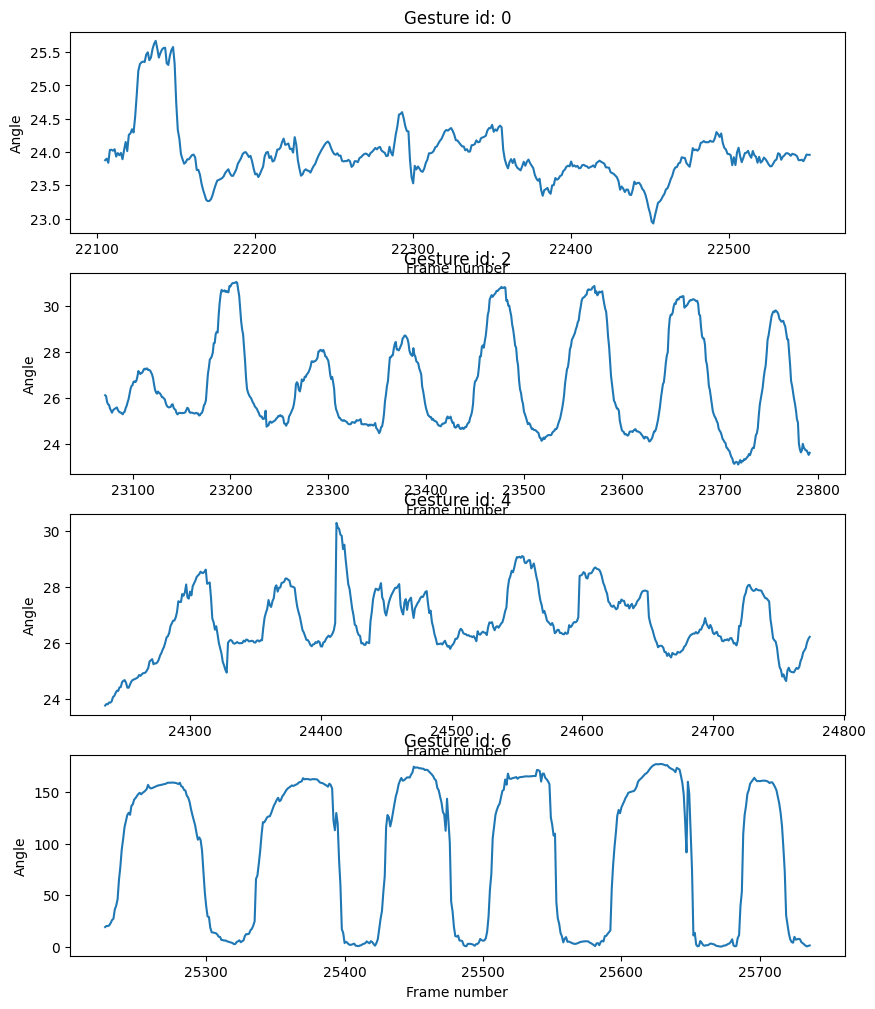

In [69]:
angle_graph(persona104, 'LeftArmAngle')